In [1]:
NAME1 = "Caroline Andersson" 
NAME2 = "Adam Burman"
GROUP = "84"

In [2]:
### Check Python version
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','9'), "You are not running Python 3.9. Make sure to run Python through the course Conda environment."

### 1.1 Imports

In [3]:


path = r"C:\Users\adamb\Documents\Skola\MPSYS\Deep Machine Learning\colorization\deep-machine-learning-colorization-project\Dataset"
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from pathlib import Path
import torchvision.transforms

from torch import nn
from torch import optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
#import colorspacious as cs


import kornia # https://kornia.readthedocs.io/en/latest/color.html
#Lab color is computed using the D65 illuminant and Observer 2. (deafult in kornia)

from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cie2000
from torchvision.transforms import Compose

In [4]:
# Check for gpu
print(torch.cuda.is_available())

False


### 1.2 Load Data

Make a dataloader class

In [5]:
# GTASemanticData
# Note: there are 19 semantic classes
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import os

class GTASemData(Dataset):
    

    def __init__(self, root, transform = None):
            """Constructor
        
        Args:
            root (Path/str): Filepath to the data root
            transform (Compose): A composition of image transforms.
        """
            root = Path(root)
            if not (root.exists() and root.is_dir()):
                raise ValueError(f"Data root '{root}' is invalid")
            
            self.root = root
            self.transform = transform
            self.img_paths, self.label_paths = self._collect_samples()
            
       
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample Tensor
        """
        
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        # Load the image and label into memory
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        
        img1 = torchvision.transforms.functional.pil_to_tensor(img) # PIL --> Tensor
        img = kornia.color.rgb_to_lab(img1/255) # RGB --> Lab
        
        L = img[0]
        a = img[1]
        b = img[2]
        
        
        # Perform transforms, if any.
        if self.transform is not None:
            L = self.transform(L.numpy()) # transform L
            label = self.transform(label) # transform
            a = self.transform(a.numpy()) # transform
            b = self.transform(b.numpy()) # transform
            
            
        
        
        ab = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), dim=0).squeeze()
        ab = ab/128
        L = (L-50)/50
        L_sem = torch.cat((L.unsqueeze(0), label.unsqueeze(0)), dim=0).squeeze()

        return L_sem, ab
    
    def __len__(self):
        """Get the number of samples in the dataset"""
        return len(self.img_paths)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        """Collect all paths and labels

        Helper method for the constructor
        """
        
        
        # Get image and label paths
        img_dir = self.root / "01_images" / "images"
        label_dir = self.root / "01_labels" / "labels"
        
        # check if there are images in the directory
        #self._check_images_in_directory(img_dir)
        #self._check_images_in_directory(label_dir)

        img_paths = list(img_dir.glob("*.png"))
        label_paths = list(label_dir.glob("*.png"))

        if len(img_paths) != len(label_paths):
            raise ValueError("Number of images and labels must be the same")
            
        return img_paths, label_paths

In [6]:
img_size = 224
transform =  Compose([ToTensor()])

example_dataset1 = GTASemData(path, transform)
print(len(example_dataset1)) #1
L_sem, ab = example_dataset1[1]

print(L_sem.shape)
print(ab.shape)
print(np.min(ab.numpy()))

"""
cmap = plt.get_cmap('tab20c')
plt.figure(figsize=(8, 4))
plt.imshow(label.numpy().squeeze(), cmap)
plt.title('Semantic Image')
plt.axis('off')
"""

24
torch.Size([2, 1052, 1914])
torch.Size([2, 1052, 1914])
-0.2992299


"\ncmap = plt.get_cmap('tab20c')\nplt.figure(figsize=(8, 4))\nplt.imshow(label.numpy().squeeze(), cmap)\nplt.title('Semantic Image')\nplt.axis('off')\n"

In [7]:
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import os

class GTALabData(Dataset):
    

    def __init__(self, root, transform = None):
            """Constructor
        
        Args:
            root (Path/str): Filepath to the data root
            transform (Compose): A composition of image transforms.
        """
            root = Path(root)
            if not (root.exists() and root.is_dir()):
                raise ValueError(f"Data root '{root}' is invalid")
            
            self.root = root
            self.transform = transform
            self.img_paths, self.label_paths = self._collect_samples()
            
       
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample Tensor
        """
        
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        # Load the image and label into memory
        img = Image.open(img_path)
        #label = Image.open(label_path)
        img1 = torchvision.transforms.functional.pil_to_tensor(img) # PIL --> Tensor
        img = kornia.color.rgb_to_lab(img1/255) # RGB --> Lab
        
        L = img[0]#kornia.color.rgb_to_grayscale(img1/255)#img[0]
        a = img[1]
        b = img[2]

        # Perform transforms, if any.
        if self.transform is not None:
            L = self.transform(L.numpy()) # transform L
            a = self.transform(a.numpy()) # transform
            b = self.transform(b.numpy()) # transform
            
            
        
        
        ab = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), dim=0).squeeze()
        #L = torch.cat((L.unsqueeze(0), L.unsqueeze(0), L.unsqueeze(0)), dim=0).squeeze()

        return (L-50)/50, ab/128
    
    def __len__(self):
        """Get the number of samples in the dataset"""
        return len(self.img_paths)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        """Collect all paths and labels

        Helper method for the constructor
        """
        
        
        # Get image and label paths
        img_dir = self.root / "01_images" / "images"
        label_dir = self.root / "01_labels" / "labels"
        
        # check if there are images in the directory
        #self._check_images_in_directory(img_dir)
        #self._check_images_in_directory(label_dir)

        img_paths = list(img_dir.glob("*.png"))
        label_paths = list(label_dir.glob("*.png"))

        if len(img_paths) != len(label_paths):
            raise ValueError("Number of images and labels must be the same")
            
        return img_paths, label_paths

In [8]:

transform = Compose([ToTensor()])

example_dataset = GTALabData(path, transform)
print(len(example_dataset)) #1
L, ab = example_dataset[2]
#print(img)
print(L.shape)
print(ab.shape)
print(np.max(L.numpy()))

24
torch.Size([1, 1052, 1914])
torch.Size([2, 1052, 1914])
1.0


### 1.3 Display Images

In [9]:
from torchvision.transforms import RandomGrayscale, ColorJitter, RandomHorizontalFlip, Resize, Normalize, RandomRotation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize_size = 128
mean = 52.37087932
std = 24.64118381
'''
# Calculate mean and standard deviation for normalization
number_of_samples = len(example_dataset)
pixelValues = []
mean = [0.0] #52.37087932 
std = [0.0] #24.64118381
for image,_ in example_dataset:
    imgArray = np.array(image)
    mean += np.mean(imgArray) / number_of_samples
    std += np.std(imgArray) / number_of_samples
print(mean)
print(number_of_samples)
'''
# ToTensor scales data between mean, std which is needed later
transform_data = Compose([ToTensor(), Resize((resize_size, resize_size), antialias=True), 
                          Normalize(mean, std, inplace=False)])

img_dataset_transformed = GTALabData(path, transform_data)
test_image_transformed, test_label = img_dataset_transformed[2]
#print(img_dataset_transformed)
#display_image(test_image, test_label) # obs! has to do the same thing on label and image!

#print(test_image[test_image<0]) # check for negative values since all must be between 0 and 1 
#(div by 255 automatically in ToTensor())

### 1.4 Augument and Normalize Data

In [10]:
from torchvision.transforms import RandomGrayscale, ColorJitter, RandomHorizontalFlip, Resize, Normalize, RandomRotation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize_size = 128
'''
# Calculate mean and standard deviation for normalization
number_of_samples = len(example_dataset)
pixelValues = []
mean = [0.0]
std = [0.0]
for image,_ in example_dataset:
    imgArray = np.array(image)
    mean += np.mean(imgArray) / number_of_samples
    std += np.std(imgArray) / number_of_samples
print(mean)
print(number_of_samples)
'''

# ToTensor scales data between mean, std which is needed later
transform_data = Compose([ToTensor(), Resize((resize_size, resize_size), antialias=True), 
                          Normalize(mean, std, inplace=False)])

img_dataset_transformed = GTALabData(path, transform_data)
test_image_transformed, test_label = img_dataset_transformed[2]
#print(img_dataset_transformed)
#display_image(test_image, test_label) # obs! has to do the same thing on label and image!

#print(test_image[test_image<0]) # check for negative values since all must be between 0 and 1 
#(div by 255 automatically in ToTensor())

In [11]:
mean = 52.37087932
std = 24.64118381
print(np.max(test_image_transformed.numpy()))

-0.9615413


### 1.5 Chop up into train, val and test

In [12]:
from torch.utils.data import random_split

# Calculate mean std
temp_dataset = GTALabData(path, ToTensor())

#test_img,_ = gta_dataset[0]
#print(test_img)
'''
number_of_samples = len(temp_dataset)
dataset_mean = []
dataset_std = []
for image,_ in temp_dataset:
    imgArray = np.array(image)
    #print(imgArray)
    dataset_mean.append(np.mean(imgArray))
    dataset_std.append(np.std(imgArray))

print(np.min(dataset_mean))
dataset_mean = np.mean(dataset_mean)
dataset_std = np.mean(dataset_std)
'''
mean = 52.37087932
std = 24.64118381
img_size = 128#224
#gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True), Normalize(mean, std, inplace=False)]) 
gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_dataset = GTALabData(path, gta_transform)

test_img, ab = gta_dataset[0]
print(np.max(test_img.numpy()))
print(np.min(test_img.numpy()))


"""
number_of_samples = len(gta_dataset)
dataset_mean = []
dataset_std = []
for image,_ in gta_dataset:
    imgArray = np.array(image)
    #print(imgArray)
    dataset_mean.append(np.mean(imgArray))
    dataset_std.append(np.std(imgArray))

print(np.max(dataset_mean))
print(np.min(dataset_mean))
    
dataset_mean = np.mean(dataset_mean)
dataset_std = np.mean(dataset_std)
    
#print(dataset_mean)
print(number_of_samples)
"""

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

train_dataset, val_dataset, test_dataset = random_split(
    gta_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

0.9710671
-0.9831371


In [13]:
"""
img_nr = 200
L, ab = train_img_dataset_transformed[img_nr]
print(ab.shape)
print(L.shape)
L=L.numpy()
a=ab[0].numpy()
b=ab[1].numpy()
#display_image(L)
#display_image(a,b)
#print(torch.max(b))
_, axis = plt.subplots(1, 3)
        
        
height, width = L.shape
axis[0].imshow(L, cmap = 'gray')
axis[0].set_xlim(0, width)
axis[0].set_ylim(height, 0)
axis[0].set_title('L')
        
height, width = a.shape
axis[1].imshow(a, cmap = 'RdYlGn')
axis[1].set_xlim(0, width)
axis[1].set_ylim(height, 0)
axis[1].set_title('a')
        
height, width = b.shape
axis[2].imshow(b, cmap = 'viridis')
axis[2].set_xlim(0, width)
axis[2].set_ylim(height, 0)
axis[2].set_title('b')
#plt.imshow(my_tensor.numpy()[0])
plt.show()
# in the opposite direction L is in range [0, 100], a,b is in range [-128, 127]

display_image(test_image)
"""

"\nimg_nr = 200\nL, ab = train_img_dataset_transformed[img_nr]\nprint(ab.shape)\nprint(L.shape)\nL=L.numpy()\na=ab[0].numpy()\nb=ab[1].numpy()\n#display_image(L)\n#display_image(a,b)\n#print(torch.max(b))\n_, axis = plt.subplots(1, 3)\n        \n        \nheight, width = L.shape\naxis[0].imshow(L, cmap = 'gray')\naxis[0].set_xlim(0, width)\naxis[0].set_ylim(height, 0)\naxis[0].set_title('L')\n        \nheight, width = a.shape\naxis[1].imshow(a, cmap = 'RdYlGn')\naxis[1].set_xlim(0, width)\naxis[1].set_ylim(height, 0)\naxis[1].set_title('a')\n        \nheight, width = b.shape\naxis[2].imshow(b, cmap = 'viridis')\naxis[2].set_xlim(0, width)\naxis[2].set_ylim(height, 0)\naxis[2].set_title('b')\n#plt.imshow(my_tensor.numpy()[0])\nplt.show()\n# in the opposite direction L is in range [0, 100], a,b is in range [-128, 127]\n\ndisplay_image(test_image)\n"

##  2. Create an Autoenconder for the Raw images
vgg16 can be used as the encoder by using transfer learning with the gtaV images. Then a decoder has to be constructed from scratch to generate a new image. The raw images are used in this section and later on another autoencoder will be trained with segmented images (our labels).

### 2.1 Create a Head for vgg16

In [14]:
from torchvision import models
#vgg_model = models.vgg16(weights = models.VGG16_Weights)

In [15]:
class VGG_head(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 1000, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0),
            nn.ConvTranspose2d(1000, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 2, kernel_size=3, padding=1),  # Output has 2 channels (ab color channels)
            nn.Tanh()  # Output values between -1 and 1
        )
        '''
        self.tc1 = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1)
        self.unpool = nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0)
        self.tc2 = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1)
        self.tc3 = nn.ConvTranspose2d(256, 32, kernel_size=3, padding=1)
        self.tc4 = nn.ConvTranspose2d(32, 2, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        '''
        print(x.shape)
        ab_channels = self.decoder(x)
        print(ab_channels.shape)
        #ab_channels = 127*ab_channels 
        '''
        print(x.shape)
        x = self.tc1(x)
        print(x.shape)
        x = self.relu(x)
         
        x = self.tc2(x)
        print(x.shape)
        x = self.relu(x)
        x = self.tc3(x)
        print(x.shape)
        #x = nn.Tanh(x)
        print(x.shape)
        return x

In [16]:
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Endocer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        
        #Decoder
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.tc1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.tc2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.tc3 = nn.Conv2d(64, 2, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        #x, indices = self.pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        
        # Decoder
        
        x = self.tc1(x)
        x = self.relu(x)
        
        x = self.tc2(x)
        x = self.relu(x)
        #x = self.unpool(x, indices)
        x = self.tc3(x)
        
        
        x = self.tanh(x)
        
        # Perform upsampling to the desired size [1052, 1914]
        #x = F.interpolate(x, size=(1052, 1914), mode='bilinear', align_corners=False)
       
        
        return x

### 2.2 Freeze and Train 

In [17]:
#base_model = nn.Sequential(vgg_model.features, VGG_head())
#print(base_model.parameters)
# Freeze all the parameters in the VGG16 model
#for param in base_model.parameters():
#    param.requires_grad = False

In [18]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(model, optimizer, loss_fn, train_loader, device, print_every)
        val_loss = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {train_loss:.3f}, "
              f"Val. loss: {val_loss:.3f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn, train_loader, device, print_every):
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(inputs)
        loss = loss_fn(z, labels)
        #print(np.min(z.detach().cpu().numpy())) #kan max bli 1????
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        if print_every is not None and batch_index % print_every == 0:
            model.train()
            print(f"Batch {batch_index}/{num_batches}: Train loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}")

    return model, sum(train_loss_batches) / len(train_loss_batches)

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model(inputs)
            batch_loss = loss_fn(z, labels)
            val_loss_cum += batch_loss.item()
    return val_loss_cum / len(val_loader)


In [19]:
# YOUR CODE HERE
batch_size = 2
base_model = AutoEncoder()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(base_model.parameters(), lr =0.001)
loss_fn = nn.MSELoss()
num_epochs = 5
print_every = 5


    
trained_gta_model, train_losses, val_losses = training_loop(base_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 5/9: Train loss: 0.004
Epoch 1/5: Train loss: 0.004, Val. loss: 0.001
Batch 5/9: Train loss: 0.002
Epoch 2/5: Train loss: 0.002, Val. loss: 0.003
Batch 5/9: Train loss: 0.002
Epoch 3/5: Train loss: 0.002, Val. loss: 0.002
Batch 5/9: Train loss: 0.002
Epoch 4/5: Train loss: 0.002, Val. loss: 0.002
Batch 5/9: Train loss: 0.002
Epoch 5/5: Train loss: 0.002, Val. loss: 0.002


### 2.4 Evaluate Performance

[0.0014927429729141295, 0.002768652862869203, 0.001821668352931738, 0.0019007365917786956, 0.00245555373840034]


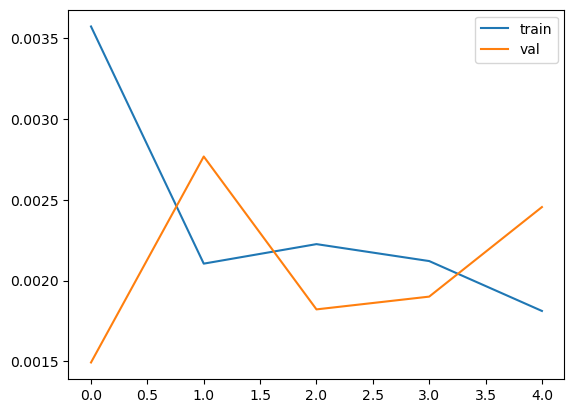

In [20]:
print(val_losses)
plt.figure()
plt.plot(range(0,len(train_losses)), train_losses)
plt.plot(range(0,len(val_losses)), val_losses)
plt.legend(['train', 'val'])
plt.show()


17.406794


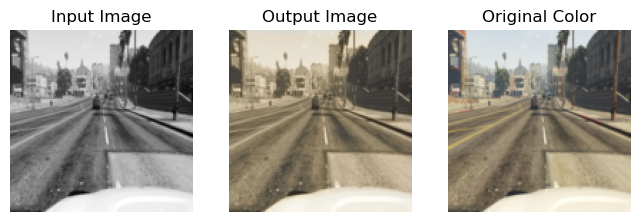

17.406689


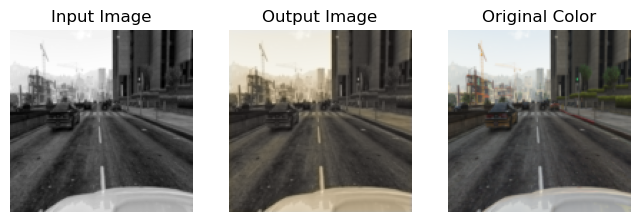

17.42373


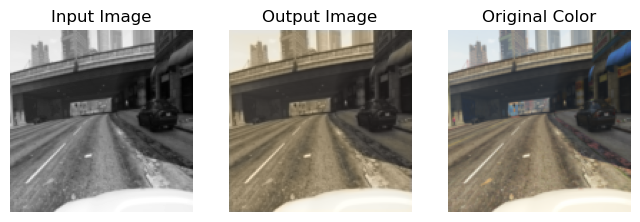

In [21]:

trained_gta_model.eval()
test_image = train_dataset[0][0]
#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_gta_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        print(np.max(output_img.numpy()))
        

        # Network computed image
        color_img = torch.cat((input_img.unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)


        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_img)
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

#output = trained_gta_model(test_image)
#test_dataloader = DataLoader()

### 2.3 Create a Decoder (outputs a,b)

## 3. Create a Network for Semantic Segmentation

In [36]:
import torch.nn.functional as F

class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Endocer
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        
        #Decoder
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.tc1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.tc2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.tc3 = nn.Conv2d(64, 2, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        #x, indices = self.pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        
        # Decoder
        
        x = self.tc1(x)
        x = self.relu(x)
        
        x = self.tc2(x)
        x = self.relu(x)
        #x = self.unpool(x, indices)
        x = self.tc3(x)
        
        
        #x = self.tanh(x)
        
        # Perform upsampling to the desired size [1052, 1914]
        #x = F.interpolate(x, size=(1052, 1914), mode='bilinear', align_corners=False)
       
        
        return x

In [37]:
#mean = 52.37087932
#std = 24.64118381
img_size = 224
#gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True), Normalize(mean, std, inplace=False)]) 
gta_sem_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_sem_dataset = GTASemData(path, gta_sem_transform)

test_img, ab = gta_dataset[0]
print(np.max(test_img.numpy()))
print(np.min(test_img.numpy()))


val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_sem_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

train_dataset, val_dataset, test_dataset = random_split(
    gta_sem_dataset, [n_train_samples, n_val_samples, n_test_samples]
)





# YOUR CODE HERE
batch_size = 6

#in_channels = 1
#out_channels = 19
base_model = SegModel()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(base_model.parameters(), lr =0.001)
loss_fn = nn.MSELoss()
num_epochs = 5
print_every = 5


    
trained_gta_sem_model, train_losses, val_losses = training_loop(base_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

0.9710671
-0.9831371
Starting training
Epoch 1/5: Train loss: 0.004, Val. loss: 0.002
Epoch 2/5: Train loss: 0.003, Val. loss: 0.003
Epoch 3/5: Train loss: 0.003, Val. loss: 0.002
Epoch 4/5: Train loss: 0.002, Val. loss: 0.002
Epoch 5/5: Train loss: 0.002, Val. loss: 0.002


[0.0022157561033964157, 0.002770213410258293, 0.001641149166971445, 0.0021699185017496347, 0.001578560913912952]


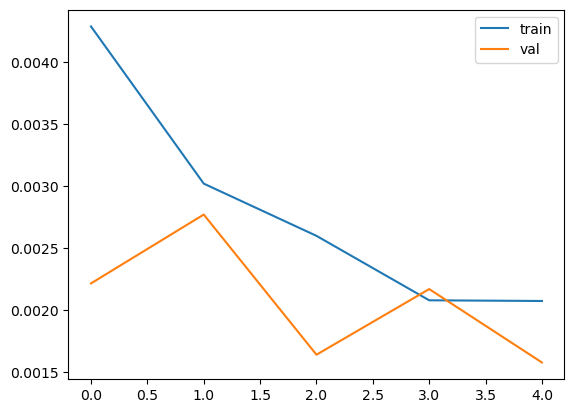

In [38]:
print(val_losses)
plt.figure()
plt.plot(range(0,len(train_losses)), train_losses)
plt.plot(range(0,len(val_losses)), val_losses)
plt.legend(['train', 'val'])
plt.show()


-0.75871193
10.2352495


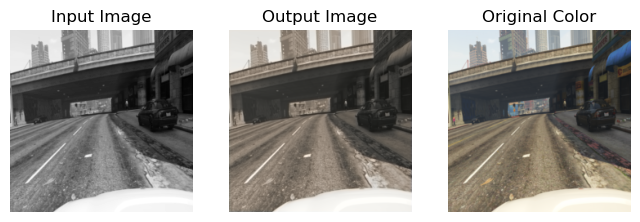

-0.85655546
10.97596


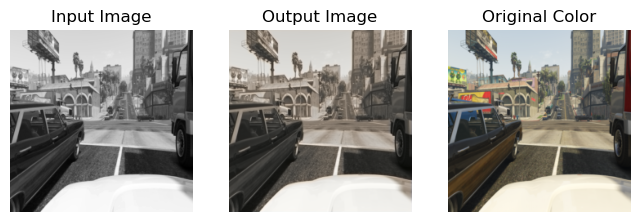

-0.738005
10.693054


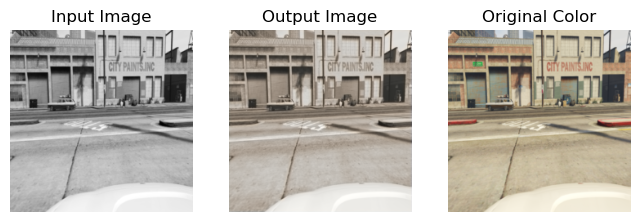

In [40]:

trained_gta_sem_model.eval()
test_image = train_dataset[0][0]
#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_gta_sem_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        #print(output_img)
        print(np.min(output_img.numpy()))
        print(np.max(output_img.numpy()))
        

        # Network computed image
        color_img = torch.cat((input_img[0].unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        original_color_image = torch.cat((input_img[0].unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)


        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img[0], cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_img)
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

#output = trained_gta_model(test_image)
#test_dataloader = DataLoader()

## 4. Create an Autoencoder that uses the Network  in 3.

Combine Semantic segmentation with a new autoencoder to colorize images.

## 5. Compare the Two Autoencoders